In [26]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [23]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [27]:
QUBITS_NUM = 4 
N = 16
K = 4
NUM_SHOTS = 1024
NUM_ITERATIONS = 50

w = 0.5

approximated_energies = []

### Simulator Backend

In [30]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [31]:
from scipy.optimize import minimize

### K input states (computational basis)

In [32]:
from utiles import *

In [33]:
input_states = get_first_k_eigenvectors_from_n_computational_basis(K, N)

### Ansatz State

In [34]:
from ansatz_circuit_item2 import get_full_variational_quantum_circuit

In [35]:
init_circuit_params = {
    "thetas": np.random.uniform(low=0, high=2*np.pi, size=8),
    "phis": np.random.uniform(low=0, high=2*np.pi, size=4),
    "D1": 2,
    "D2": 6
}

In [36]:
def prepare_circuit_params(thetas) -> Dict:
     return {
    "thetas": thetas[4:],
    "phis": thetas[:4],
    "D1": 2,
    "D2": 6
     }

In [37]:
def get_ansatz_state(circuit_params, input_state):
    circuit_params_with_input_state = {**circuit_params, "input_state": input_state}
    return get_full_variational_quantum_circuit(**circuit_params_with_input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [38]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [39]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [40]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [41]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [42]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [43]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [44]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [45]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in zip(pauli_coeffs, pauli_strings):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [46]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian):
    circuit_params = prepare_circuit_params(thetas)
    computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    k_ansatz_state = get_ansatz_state(circuit_params, computational_eigenvectors[K-1])
    
    approximated_energey = get_expectation_value(k_ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(approximated_energey)
    
    L_w = w*approximated_energey
    for j in range(K-1):
        ansatz_state = get_ansatz_state(circuit_params, computational_eigenvectors[j])
        L_w += get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
        
    return L_w

## Optimization

In [47]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=12)
    optimizer_result = minimize(cost_function,x0=initial_thetas,args=(hamiltonian),method="BFGS",options={"maxiter":NUM_ITERATIONS})
    optimal_thetas = prepare_circuit_params(optimizer_result.x)
    
    return optimal_thetas

In [48]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian)
    print(optimal_thetas)
    computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, computational_eigenvectors[K-1])
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [39]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [40]:
def get_k_exact_eigenvalue_of_hamiltonian(hamiltonian, k):
    eigen_values = LA.eig(hamiltonian.to_matrix())[0]
    print(sorted(eigen_values, reverse=True))
    
    return sorted(eigen_values,reverse=True)[k-1]

In [41]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_k_exact_eigenvalue_of_hamiltonian(hamiltonian, K)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("Approximated K Eigenvalues:")
    print(approximated_eigenvalue)

    print("Approximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))

## Visualization

In [50]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [5]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies[:100])
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [ ]:
LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

In [53]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits)

{'thetas': array([2.82258278, 4.3404669 , 0.79154605, 4.43780094, 3.85846306,
       5.20624176, 3.47137726, 0.33638891]), 'phis': array([3.27814311, 4.09006187, 2.08909765, 2.17829448]), 'D1': 2, 'D2': 6}
CPU times: total: 1h 7min 52s
Wall time: 1h 18min 49s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

In [91]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

[(-6.769813218087976+0j), (-7.130406955301308+0j), (-7.130406955301309+0j), (-7.151525481896562+0j), (-7.364817440287081+0j), (-7.511999706834451+0j), (-7.511999706834453+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.700475837803976+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.7140566916607005+0j), (-7.783396208286518+0j), (-7.7833962082865185+0j), (-7.862773163027979+0j)]
exact_eigen_value:
(-7.151525481896562+0j)
approximated_eigen_value:
-7.091584422104367
approximation error
0.008381576762039203


In [55]:
print(approximated_energies)
approximated_energies = []

[-7.086471480342895, -7.100658534270067, -7.099715987203259, -7.104706322802394, -7.0881767422400515, -7.094941901238781, -7.101189782415803, -7.091782649949064, -7.095129380762572, -7.089782186084561, -7.103641494347653, -7.08770304365008, -7.097466178879243, -6.927386893001271, -6.918605722866235, -6.929889900623873, -6.929547677497744, -6.9144751585444, -6.92705204011207, -6.928594209576469, -6.918356322098606, -6.922146575259048, -6.928167910638778, -6.920735015129623, -6.934524032800371, -6.9240609972824645, -7.054992091903585, -7.056718682779798, -7.047680065570422, -7.057958949601671, -7.049809365284406, -7.04886498241836, -7.061382947330433, -7.047727314056423, -7.05595544969352, -7.0549833626221155, -7.064687065647647, -7.04480704575676, -7.053986384203245, -7.079305098939433, -7.08780253307097, -7.079683274206787, -7.082864577262481, -7.074313240029014, -7.076075827379148, -7.094328957871822, -7.08496554875689, -7.08017425919163, -7.080091087607597, -7.091782059567345, -7.091

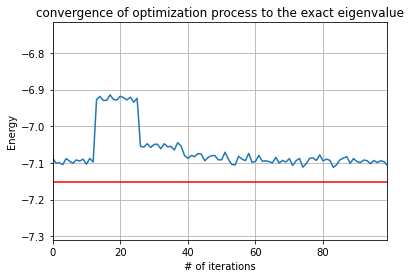

In [6]:
LiH_approximated_energies = [-7.086471480342895, -7.100658534270067, -7.099715987203259, -7.104706322802394, -7.0881767422400515, -7.094941901238781, -7.101189782415803, -7.091782649949064, -7.095129380762572, -7.089782186084561, -7.103641494347653, -7.08770304365008, -7.097466178879243, -6.927386893001271, -6.918605722866235, -6.929889900623873, -6.929547677497744, -6.9144751585444, -6.92705204011207, -6.928594209576469, -6.918356322098606, -6.922146575259048, -6.928167910638778, -6.920735015129623, -6.934524032800371, -6.9240609972824645, -7.054992091903585, -7.056718682779798, -7.047680065570422, -7.057958949601671, -7.049809365284406, -7.04886498241836, -7.061382947330433, -7.047727314056423, -7.05595544969352, -7.0549833626221155, -7.064687065647647, -7.04480704575676, -7.053986384203245, -7.079305098939433, -7.08780253307097, -7.079683274206787, -7.082864577262481, -7.074313240029014, -7.076075827379148, -7.094328957871822, -7.08496554875689, -7.08017425919163, -7.080091087607597, -7.091782059567345, -7.091247992689509, -7.070866930379006, -7.090286264563848, -7.104283776653907, -7.105507768659804, -7.082013868585181, -7.089272262553638, -7.093947194681023, -7.074106629342778, -7.098394252872861, -7.0959686725785405, -7.07952225336062, -7.095513342542343, -7.09416071736501, -7.096369979461571, -7.099848242069214, -7.084955688773306, -7.100455873892028, -7.093183696883554, -7.0975872306150345, -7.088097397700704, -7.106647897103562, -7.093977686069661, -7.087712543786841, -7.111504280126781, -7.1022363547755125, -7.087493749330183, -7.086287626873361, -7.093369560806178, -7.078161435586905, -7.09441449134148, -7.089607689893512, -7.0932238396900935, -7.111989359310854, -7.104929885548429, -7.091436536609016, -7.08666585935681, -7.082934757346767, -7.101100532138134, -7.088104163062988, -7.096424567809472, -7.099068194469176, -7.092174139685106, -7.093834778605302, -7.102211865551155, -7.093273952141729, -7.098925944110142, -7.094136827312879, -7.096515152172171, -7.106869073487611, -7.105025480517323, -7.08291256775595, -7.090057760157153, -7.101077914837238, -7.098981572929163, -7.103243624466709, -7.081271774215078, -7.113017035519717, -7.081225379146937, -7.116834711504442, -7.095492739824888, -7.092682578748099, -7.101013785481937, -7.1014895178629045, -7.089392729188864, -7.107015846039383, -7.098163688087048, -7.111610506727951, -7.107437432724649, -7.104541043920935, -7.104814557146702, -7.088507490097296, -7.091868681777208, -7.092327160052328, -7.110303366341896, -7.084971369187621, -7.106279269575924, -7.08748298127782, -7.1068551105826145, -7.091008955160712, -7.096443978916333, -7.084657042850862, -7.091138219995237, -7.0998677627359195, -7.0888015973421545, -7.077323969498798, -7.090075437365467, -7.103938600828348, -7.085513121721133, -7.093846377275633, -7.100739101641138, -7.092065649168193, -7.094889058778457, -7.092173541005391, -7.101259881230652, -7.093329510244533, -7.105936945903171, -7.087603313944616, -7.097873442997792, -7.101002397868193, -7.085514640470669, -7.104346225751653, -7.108225666766319, -7.111418621976149, -7.092840805395079, -7.0997679722989115, -7.103255616021782, -7.1174210275723695, -7.102934036335791, -7.094670120993602, -7.0951047953871305, -7.089065125835845, -7.09840645780722, -7.105211057511607, -7.089083299917603, -7.093536455196501, -7.089028853201778, -7.085106562924485, -7.094025566715013, -7.093679961728104, -7.097635614184673, -7.097876397476181, -7.094228767292644, -7.095176655148256, -7.098376263483634, -7.103892028959518, -7.086136465046034, -7.087496098005651, -7.116101776894849, -7.0836112045512705, -7.087318451256026, -7.089288193935741, -7.0990242642314785, -7.095138019651596, -7.098662991437872, -7.094562027567983, -7.099690770432304, -7.10097689047591, -7.103828491824173, -7.095403813862108, -7.092482494208955, -7.0961542900231755, -7.097735395547859, -7.101840243383003, -7.094728079435617, -7.089079166461775, -7.0918303529233695, -7.093445910102374, -7.0824677848419855, -7.088613823891637, -7.094448016211003, -7.102567463647013, -7.093674126629666, -7.107515891897475, -7.091175773435145, -7.099878612823926, -7.108888487835898, -7.0932901938871025, -7.100690499032453, -7.1027627009989205, -7.095985679639996, -7.103159134683138, -7.101594099093457, -7.09708690219646, -7.089839220984511, -7.110835783093937, -7.1106173669768005, -7.105706223928073, -7.101671068636789, -7.093043127308357, -7.107499275434534, -7.098620367705562, -7.101791302589503, -7.093974565602916, -7.100086270996543, -7.103967087697664, -7.096334501266853, -7.093197040678562, -7.090566503804324, -7.10777548347143, -7.0940663715743515, -7.079435919407288, -7.1045995778828575, -7.10782600555929, -7.095063062315657, -7.088283716422724, -7.083549548308807, -7.109182438307642, -7.0973139726115155, -7.091323880662006, -7.089267567957862, -7.093801064885492, -7.096478431968507, -7.096450570087517, -7.0834951672860145, -7.105536970385327, -7.091694022844323, -7.0987246829979735, -7.105823728075208, -7.091466927556181, -7.087866391118642, -7.086779542808011, -7.082284206870279, -7.102748671032144, -7.094013649749645, -7.076280227170458, -7.09268421659322, -7.098730097915838, -7.095792848436216, -7.090464809457003, -7.098254342554415, -7.098030162423567, -7.0935066669889375, -7.086557591264656, -7.102526761243724, -7.098181739651888, -7.10872784155506, -7.097459195380401, -7.095191100812662, -7.102890507504376, -7.0923183296893795, -7.102156393269663, -7.09845792437554, -7.096080365452766, -7.10013103533166, -7.1005268316155945, -7.092915662727403, -7.095654857173873, -7.10922258172602, -7.099831667590216, -7.108845117487635, -7.082825083394153, -7.09107742992335, -7.077237571417883, -7.096191060913464, -7.0969085540182455, -7.114145172610189, -7.108437033980985, -7.105356395396853, -7.102301352541805, -7.103938890772344, -7.101405935547222, -7.1113452563763815, -7.0947122361413415, -7.099371225641347, -7.102428612231857, -7.080811315146189, -7.091175823108694, -7.1006602596540445, -7.085633248686943, -7.101715269263441, -7.0835485945728305, -7.0994928231977195, -7.09758387589104, -7.0795693729863505, -7.093444335523969, -7.102404867274401, -7.09942952825781, -7.092772226440181, -7.104709368820088, -7.098167881166478, -7.090812612388616, -7.104342211111905, -7.095634875814595, -7.092173851473915, -7.096806777226616, -7.104061399180975, -7.103310800731109, -7.083274172204216, -7.097915562847112, -7.077818214117743, -7.083628375959302, -7.093476904190158, -7.089513462892567, -7.090304705450007, -7.093392779706353, -7.10554680082769, -7.088962810558666, -7.091859039419992, -7.095055353625999, -7.095717126988325, -7.083592132581408, -7.100324224161871, -7.0785000809768714, -7.105908001716903, -7.093818438314592, -7.098883881335108, -7.104431926558294, -7.099627499021038, -7.092250021905359, -7.0907944678741535, -7.09293707780021, -7.091586685769627, -7.089190047620321, -7.1018597532027385, -7.100262126701205, -7.09131145193086, -7.09482991668717, -7.088031963725242, -7.09771658959787, -7.089270186131905, -7.096846356920972, -7.09686896582669, -7.092845267851078, -7.11130293906202, -7.091518158249563, -7.094435352643231, -7.097573980280066, -7.097401803322267, -7.09679214923423, -7.096140093891424, -7.105779785807971, -7.101284059739653]
plot_convergence_of_optimization_process(LiH_approximated_energies, exact_eigenvalue=-7.151525481896562,margin=1)

## H2 Molecule 4 qubits

In [56]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

In [57]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits)

{'thetas': array([3.21479431, 3.40765518, 1.58542217, 4.79660827, 1.43026731,
       3.48369346, 6.0691676 , 0.5039953 ]), 'phis': array([2.17897472, 3.29472689, 2.17388579, 1.7643023 ]), 'D1': 2, 'D2': 6}
CPU times: total: 19min 36s
Wall time: 20min 26s


In [93]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

[(0.2142782384194731+0j), (-1.942890293094024e-16+0j), (-0.2249112528308709+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.47189600728114245+0j), (-0.47189600728114256+0j), (-0.8827221502448648+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-1.244584549813327+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.2563390730032498+0j), (-1.25633907300325+0j), (-1.8572750302023793+0j)]
exact_eigen_value:
(-0.353325104107155+0j)
approximated_eigen_value:
-0.6201232170177535
approximation error
0.7551065854343739


In [59]:
print(approximated_energies)
approximated_energies = []

[-0.6479084750255486, -0.6276579569919597, -0.6079422008169065, -0.616731159779808, -0.6325842283091055, -0.6393897280901208, -0.6171807581727554, -0.632653791572579, -0.6213172282987715, -0.6295655663398093, -0.6289772030449229, -0.6186181091776035, -0.624022941533276, -0.5082839240612291, -0.48226570208794234, -0.4821361107003052, -0.4954020352078101, -0.4793435904590445, -0.49199670120300654, -0.49416478838441447, -0.502190052373643, -0.49599755978221166, -0.5020643548684793, -0.4889205213711024, -0.5018939914800866, -0.5099878400191491, -0.5856552068715944, -0.54923382599589, -0.5582306982767166, -0.5444314531693122, -0.5567710700669415, -0.5659113697818672, -0.552668511160273, -0.5735134318844516, -0.549852476753314, -0.5503189869962759, -0.5601864836520486, -0.5659896127460298, -0.5446950460298908, -0.615920984439197, -0.5928640404070656, -0.5879106801498322, -0.5935911543775607, -0.6075920247035514, -0.6201194518598445, -0.60623970115924, -0.6162790804378995, -0.6070899791213487

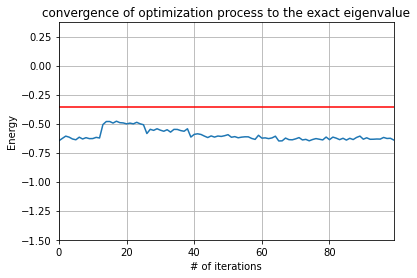

In [7]:
H2_approximated_energies = [-0.6479084750255486, -0.6276579569919597, -0.6079422008169065, -0.616731159779808, -0.6325842283091055, -0.6393897280901208, -0.6171807581727554, -0.632653791572579, -0.6213172282987715, -0.6295655663398093, -0.6289772030449229, -0.6186181091776035, -0.624022941533276, -0.5082839240612291, -0.48226570208794234, -0.4821361107003052, -0.4954020352078101, -0.4793435904590445, -0.49199670120300654, -0.49416478838441447, -0.502190052373643, -0.49599755978221166, -0.5020643548684793, -0.4889205213711024, -0.5018939914800866, -0.5099878400191491, -0.5856552068715944, -0.54923382599589, -0.5582306982767166, -0.5444314531693122, -0.5567710700669415, -0.5659113697818672, -0.552668511160273, -0.5735134318844516, -0.549852476753314, -0.5503189869962759, -0.5601864836520486, -0.5659896127460298, -0.5446950460298908, -0.615920984439197, -0.5928640404070656, -0.5879106801498322, -0.5935911543775607, -0.6075920247035514, -0.6201194518598445, -0.60623970115924, -0.6162790804378995, -0.6070899791213487, -0.6105620077787796, -0.604279338203177, -0.5953765787888684, -0.6176510100281449, -0.6121876903025966, -0.6221925707825862, -0.6167720694769763, -0.6138135616671906, -0.6141332165079305, -0.6280212409220817, -0.6360069982326235, -0.6007258601159454, -0.6251861183198779, -0.6230618384361196, -0.6294049945914133, -0.6233533946933156, -0.608497712991425, -0.6496414061454564, -0.6486467922145787, -0.6248046230879923, -0.6382435950247505, -0.6396933212611499, -0.6313975747684536, -0.6205882624714589, -0.6408121049037772, -0.6358325058878442, -0.6483418584555031, -0.6371649113759628, -0.6291839190391355, -0.6347573834032361, -0.6407098912056699, -0.6159176260854965, -0.6384554645835627, -0.6164080207309359, -0.625543079338974, -0.6382937503891668, -0.6264097132175528, -0.6420718561520969, -0.6267262725213436, -0.6374963711667498, -0.6193193504433864, -0.6078143278866533, -0.634472486357409, -0.6223512323012782, -0.6351163020561015, -0.634661177023637, -0.6327899211075433, -0.6336448686497769, -0.6193351633432258, -0.6281755978797693, -0.6264777231208046, -0.6414830476329384, -0.6307683399864691, -0.6307085701314388, -0.6206080402310008, -0.6348255969934301, -0.6396136598903551, -0.6119662685652434, -0.6416707355866279, -0.6413693107560723, -0.6177947197203094, -0.6298765228276698, -0.6523529064199631, -0.6449003109571184, -0.653383311719062, -0.6114270075961685, -0.6288547938898695, -0.618693644838608, -0.6474406100562011, -0.6311230491106903, -0.6116401562656182, -0.636431790506111, -0.6291838050229098, -0.6323232015973214, -0.6084567336875317, -0.6260410898582017, -0.6558980736383361, -0.6088478495140429, -0.6362772541154403, -0.6229687283270671, -0.6337477882049586, -0.6146890139542273, -0.6109822191193143, -0.6410668717503976, -0.6050360295204666, -0.6127109227117324, -0.613969481075047, -0.6330316470359499, -0.6336428860578563, -0.6579205656897767, -0.6226609914498723, -0.6308197002529959, -0.6592780043421462, -0.6286105470576249, -0.6142144474532307, -0.6308763800946607, -0.6313362339145869, -0.6587453552909762, -0.6439616021766039, -0.6342588475726809, -0.6348805630323535, -0.612208176680939, -0.6384209891698392, -0.6377259399102154, -0.6288355030414153, -0.6254287723561084, -0.6267028568621377, -0.633225553954038, -0.6266439989301029, -0.6219787315736918, -0.6444478946498267, -0.6078647889145464, -0.6169625336670495, -0.6228416937169068, -0.6055808453138738, -0.6349070986052844, -0.6233134657244299, -0.638807727216456, -0.6439324406558855, -0.6290682438485403, -0.6347278678305891, -0.6370807223116214, -0.6331202879928073, -0.6259391405710086, -0.6205239729014943, -0.6271330693467981, -0.6384914098927226, -0.6540996612097635, -0.6297277932870161, -0.6230026756130547, -0.6337458840743901, -0.6269616938156711, -0.6071713916280417, -0.6182364077263139, -0.6295847748388186, -0.6340000050667973, -0.662525648783056, -0.6268357485227919, -0.6383142008116837, -0.6356494637389134, -0.6334179386720562, -0.6368477711503842, -0.6258766827515051, -0.6250225216677815, -0.6402120922677865, -0.6215866553687236, -0.6300458164726813, -0.6349074242618946, -0.6281512038322912, -0.6106861518433435, -0.6257220729152266, -0.6264637065414248, -0.6413022282257185, -0.6287300650968061, -0.6415216331142828, -0.6177784438217981, -0.6235031629550336, -0.6522908854196745, -0.6433100700195024, -0.6467856500499529, -0.6383906423809346, -0.6353007399215785, -0.628267887248418, -0.6530534039557805, -0.6489154837903043, -0.6251303963665552, -0.606115215627397, -0.640564227336403, -0.6426262151446616, -0.6375465819155562, -0.6241657686495026, -0.6365874044036779, -0.6368987773426885, -0.6254336505997881, -0.6195698003196071, -0.6312797723656407, -0.6493745786523953, -0.6255032951930553, -0.6076271422511403, -0.6369485503847903, -0.633978893260772, -0.6247995690801257, -0.6181592078851024, -0.6413113581396256, -0.6357432503116383, -0.6413681655967249, -0.6349930744741815, -0.6553915345015394, -0.6333982709804692, -0.6323784240845362, -0.597462603561814, -0.6354799343741077, -0.6435513818689228, -0.6288306285283861, -0.6252986455639116, -0.6338258059332423, -0.6354797897494069, -0.6118871374772903]
plot_convergence_of_optimization_process(H2_approximated_energies, exact_eigenvalue=-0.353325104107155, margin=5)

####  Transverse Ising Model 4 qubits

In [32]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

In [87]:
%%time
TI_approximated_eigen_value = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits)

{'thetas': array([6.27381986, 1.60638366, 1.8023623 , 6.12549758, 0.1519137 ,
       3.89709548, 3.32623639, 2.22222496]), 'phis': array([1.83212638, 5.62815561, 2.02404182, 5.14525038]), 'D1': 2, 'D2': 6}
CPU times: total: 16min 21s
Wall time: 32min 28s


In [94]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

[(2.3867070442313216+0j), (2.3718326043433704+0j), (1.6958488386667439+0j), (1.6816520928402046+0j), (0.3444947223438019+0j), (0.2757654176709828+0j), (0.20992649961322052+0j), (0.14239915569453057+0j), (-0.2505930484227001+0j), (-0.31907768442618767+0j), (-0.47710503946487287+0j), (-0.5462047134056278+0j), (-1.7583827504312988+0j), (-1.8497137109270194+0j), (-1.9080638482930956+0j), (-1.9994855800333675+0j)]
exact_eigen_value:
(1.6816520928402046+0j)
approximated_eigen_value:
1.6419669558757568
approximation error
0.02359889844838361


In [89]:
print(approximated_energies)
approximated_energies = []

[1.6648411153880571, 1.6194607759680062, 1.6366342809362835, 1.671571409257757, 1.6674504314028746, 1.6414608280012988, 1.6374332277143029, 1.6393456320451176, 1.6656301010271155, 1.6373945433165997, 1.6644743123580934, 1.618607318856929, 1.6450503901651206, 1.5458317310538965, 1.5397695405859546, 1.6112944041201487, 1.5539793147981404, 1.576903601706713, 1.5247645421898266, 1.5815387937261172, 1.6059622429963691, 1.5826831836546222, 1.581364447883685, 1.5953720749673383, 1.5401014401253998, 1.6454641139045152, 1.5869288844162863, 1.5928378701093548, 1.583960654629803, 1.5477672318681797, 1.600878869946812, 1.5830187621655059, 1.5838105560062876, 1.5711380135625521, 1.6087065887746852, 1.5794014387098523, 1.5687981464469034, 1.5879697110914726, 1.6103639647889736, 1.6544655997774775, 1.6284747442130143, 1.6323685549129423, 1.6432565842590559, 1.6121303469240333, 1.658899134266317, 1.6179606539650035, 1.6023248851119496, 1.636346170040315, 1.646543022806545, 1.5986537858603425, 1.641248

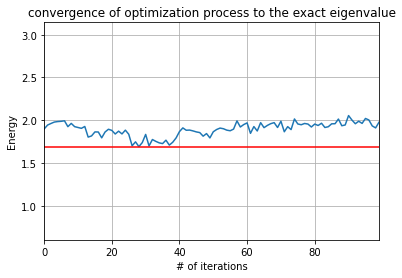

In [8]:
TI_approximated_energies = [1.8984375, 1.943359375, 1.9619140625, 1.978515625, 1.984375, 1.9873046875, 1.9931640625, 1.9248046875, 1.962890625, 1.9248046875, 1.9150390625, 1.9052734375, 1.9267578125, 1.802734375, 1.81640625, 1.86328125, 1.8623046875, 1.7939453125, 1.8623046875, 1.89453125, 1.880859375, 1.8388671875, 1.8720703125, 1.83984375, 1.8837890625, 1.8359375, 1.701171875, 1.7470703125, 1.69140625, 1.73828125, 1.833984375, 1.69921875, 1.7744140625, 1.7529296875, 1.7353515625, 1.7265625, 1.7666015625, 1.708984375, 1.7421875, 1.79296875, 1.8671875, 1.91015625, 1.8828125, 1.884765625, 1.875, 1.86328125, 1.85546875, 1.8134765625, 1.84375, 1.79296875, 1.865234375, 1.8916015625, 1.908203125, 1.900390625, 1.8837890625, 1.876953125, 1.896484375, 1.9921875, 1.9208984375, 1.94921875, 1.96875, 1.8466796875, 1.92578125, 1.8740234375, 1.9716796875, 1.9130859375, 1.939453125, 1.9599609375, 1.9716796875, 1.9150390625, 1.98828125, 1.865234375, 1.9248046875, 1.890625, 2.0146484375, 1.9560546875, 1.947265625, 1.9619140625, 1.955078125, 1.9208984375, 1.955078125, 1.9384765625, 1.96484375, 1.9150390625, 1.923828125, 1.9580078125, 1.958984375, 2.013671875, 1.935546875, 1.9443359375, 2.0546875, 2.001953125, 1.958984375, 1.98828125, 1.962890625, 2.0205078125, 2.0029296875, 1.93359375, 1.91015625, 1.9765625, 1.9365234375, 1.8984375, 1.9072265625, 1.939453125, 1.9033203125, 2.0556640625, 1.947265625, 1.9267578125, 1.9541015625, 1.962890625, 1.9287109375, 1.9072265625, 1.962890625, 1.966796875, 1.9560546875, 1.970703125, 1.9580078125, 1.9833984375, 2.013671875, 1.966796875, 1.9599609375, 1.943359375, 1.974609375, 1.9619140625, 1.9462890625, 1.974609375, 1.9482421875, 1.943359375, 1.9697265625, 1.9033203125, 1.9794921875, 1.98828125, 1.94140625, 1.9658203125, 2.0078125, 1.9912109375, 1.916015625, 1.916015625, 2.0068359375, 1.9130859375, 1.9267578125, 1.90234375, 1.921875, 1.943359375, 1.9755859375, 1.90234375, 1.95703125, 1.9482421875, 1.97265625, 1.9658203125, 1.990234375, 1.9384765625, 1.935546875, 1.916015625, 1.91796875, 1.99609375, 1.87109375, 1.9599609375, 1.919921875, 1.951171875, 1.9521484375, 1.9716796875, 1.9736328125, 1.9794921875, 1.99609375, 1.9765625, 1.9228515625, 1.9482421875, 1.9462890625, 1.986328125, 1.927734375, 1.9482421875, 2.0771484375, 2.0009765625, 1.9267578125, 1.9638671875, 1.904296875, 1.9365234375, 1.962890625, 1.958984375, 1.96875, 1.9521484375, 1.8935546875, 1.916015625, 1.939453125, 1.98046875, 1.9560546875, 1.9541015625, 1.955078125, 1.9228515625, 1.9951171875, 1.93359375, 1.9736328125, 1.9443359375, 1.96484375, 1.984375, 1.8681640625, 1.923828125, 1.947265625, 1.96484375, 1.94140625, 1.9375, 1.96875, 1.94921875, 1.943359375, 1.8935546875, 1.9638671875, 1.912109375, 2.0, 1.921875, 2.064453125, 1.95703125, 1.9287109375, 1.951171875, 1.982421875, 1.8955078125, 1.9482421875, 1.9970703125, 1.9423828125, 1.9697265625, 1.90625, 1.9306640625, 1.9716796875, 1.92578125, 1.98046875, 1.9521484375, 1.9072265625, 1.962890625, 1.9365234375, 1.9609375, 1.9560546875, 1.9462890625, 2.0166015625, 1.9609375, 1.9287109375, 1.962890625, 1.9677734375, 1.9169921875, 1.876953125, 1.9443359375, 1.984375, 1.9697265625, 1.978515625, 1.958984375, 1.9677734375, 2.0341796875, 1.9697265625, 1.93359375, 1.966796875, 1.9482421875, 1.9345703125, 1.9453125, 1.9912109375, 1.986328125, 1.955078125, 1.927734375, 2.03125, 1.921875, 1.951171875, 1.9990234375, 1.8955078125, 1.9794921875, 2.0078125, 1.9580078125, 1.986328125, 1.9287109375, 1.9853515625, 1.9990234375, 1.9365234375, 2.0048828125, 1.9462890625, 1.9580078125, 1.970703125, 1.951171875, 1.91015625, 1.8662109375, 1.9013671875, 1.9267578125, 1.943359375, 1.9814453125, 1.927734375, 1.99609375, 1.9580078125, 1.904296875, 1.912109375, 1.978515625, 1.9453125, 1.990234375, 1.97265625, 1.9580078125, 1.93359375, 1.9599609375, 1.986328125, 1.970703125, 1.966796875, 1.947265625, 1.875, 1.953125, 1.966796875, 1.931640625, 1.9140625, 1.98828125, 1.919921875, 1.970703125, 1.8916015625, 2.0615234375, 2.015625, 1.8466796875, 1.916015625, 1.96875, 1.9697265625, 2.0029296875, 1.9326171875, 1.939453125, 1.873046875, 1.9345703125, 1.9501953125, 1.927734375, 1.9453125, 2.005859375, 1.96484375, 1.9384765625, 1.9609375, 1.990234375, 1.951171875, 1.951171875, 1.994140625, 2.015625, 1.9462890625, 1.94140625, 2.0439453125, 1.9755859375, 1.9326171875, 2.0224609375, 1.9248046875, 1.990234375, 2.0, 1.9091796875, 1.9267578125, 1.951171875, 1.95703125, 1.9521484375]
plot_convergence_of_optimization_process(TI_approximated_energies, exact_eigenvalue=1.6816520928402046, margin=3)